In [2]:
import os, sys

sys.path.append('/home/548/cd3022/repos/aus-historical-solar-droughts/modules')

import xarray as xr
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import solar_plotting

import logging
logging.getLogger("flox").setLevel(logging.WARNING)

plt.rcParams.update({
    'axes.titlesize': 22,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

%load_ext autoreload
%autoreload 2

fig_dir = '/home/548/cd3022/figures/aus-solar-resource'
os.makedirs(fig_dir, exist_ok=True)

# For correlation matrices
def regional_correlations(da):

    data = da.dropna(dim='time', how='any')
    data = data.transpose('region', 'time')  # shape: (region, time)
    
    # Compute pairwise correlations
    reg_names = data['region'].values
    n = len(reg_names)

    corr = np.empty((n, n), dtype=np.float64)

    for i in range(n):
        for j in range(n):
            corr[i, j] = round(xr.corr(data.sel(region=reg_names[i]),
                                 data.sel(region=reg_names[j]),
                                 dim='time').item(), 2)

    return pd.DataFrame(corr, index=reg_names, columns=reg_names)

def jaccard_matrix(binary_da):
    """
    Compute the Jaccard index matrix between all pairs of regions
    from a binary xarray.DataArray (1 = drought, 0 = no drought).

    Parameters:
    ----------
    binary_da : xr.DataArray
        A 2D DataArray with dimensions ('region', 'time') and binary values.

    Returns:
    -------
    pd.DataFrame
        A symmetric matrix of Jaccard indices between regions.
    """
    if set(binary_da.values.flatten()) - {0,1}:
        raise ValueError("DataArray must be binary (0/1)")

    reg_names = binary_da.region.values
    n = len(reg_names)
    jac = np.full((n, n), np.nan)

    for i in range(n):
        bi = binary_da.sel(region=reg_names[i])
        for j in range(i, n):  # symmetric, compute only upper triangle
            bj = binary_da.sel(region=reg_names[j])

            intersection = (bi & bj).sum().item()
            union = (bi | bj).sum().item()

            if union == 0:
                score = np.nan  # or 1.0 if you want perfect match on all-zeros
            else:
                score = round(intersection / union, 2)

            jac[i, j] = score
            jac[j, i] = score  # symmetry

    return pd.DataFrame(jac, index=reg_names, columns=reg_names)

In [3]:
date = slice('2018-12-12T0710', '2018-12-12T1830')
file_path = Path('/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/v1.0/2018/12/12/')
files = [f for f in file_path.glob('*.nc')]
ds = xr.open_mfdataset(files)

# Prepare Data

In [4]:
data_dir = Path("/g/data/er8/users/cd3022/solar_drought/REZ/")
files = list(data_dir.glob("*.nc"))
datasets = []

for file in files:
    region_name = file.stem[0:2]
    ds_reg = xr.open_dataset(file)
    ds_reg = ds_reg.expand_dims(region=[region_name])

    datasets.append(ds_reg)

ds = xr.concat(datasets, dim='region')

# Change times to AEST
time_utc = pd.to_datetime(ds.time.values)
time_aest = time_utc.tz_localize("UTC").tz_convert("Australia/Brisbane")
time_aest_naive = time_aest.tz_convert("Australia/Brisbane").tz_localize(None)
ds = ds.assign_coords(time=("time", time_aest_naive))

# Remove missing time step
ds = ds.where(ds['time'].dt.strftime('%H:%M') != '12:40', drop=True)

# Convert generation to capacity factor
rated_capacity = 219.656729124
ds = ds / rated_capacity

# # Clip dusk and dawn from each day
for var in ds.data_vars:
    for reg in ds.region:
        	ds[var].sel(region=reg)[:] = solar_plotting.clip_dusk_dawn(ds[var].sel(region=reg), n=6) # n=6 for 6 time steps, i.e. one hour clippled from each end

# Reorder regions for logical figures
order = ['Q2', 'Q8', 'N3', 'N5', 'V2', 'V4', 'T1', 'T3', 'S8', 'S7']
ds = ds.sel(region=order)

# Get just the 9 full years
ds = ds.sel(time=slice('2016', '2024'))


# Remove days with bad data
bad_days = [
    np.datetime64('2018-02-13'), # missing data
    np.datetime64('2018-02-14'), # missing data (whole day)
    np.datetime64('2019-08-12'), # NWP data error
    np.datetime64('2019-10-01'), # NWP data error
    np.datetime64('2020-09-06'), # NWP data error
    
]
ds_dates = ds['time'].dt.floor('D')
good_time_mask = ~ds_dates.isin(bad_days)
ds = ds.sel(time=ds['time'][good_time_mask])

# Colours for plotting
rez_colours = {
    'Q2':'#B31919',
    'Q8': '#E33B3B',
    'N3': '#E06C00',
    'N5': '#FF9633',
    'V2': '#610345',
    'V4': '#9E0570',
    'T1': '#044B7F',
    'T3': '#0676C6',
    'S8': '#63934D',
    'S7': '#7FB069'
}

# CSI Demonstration

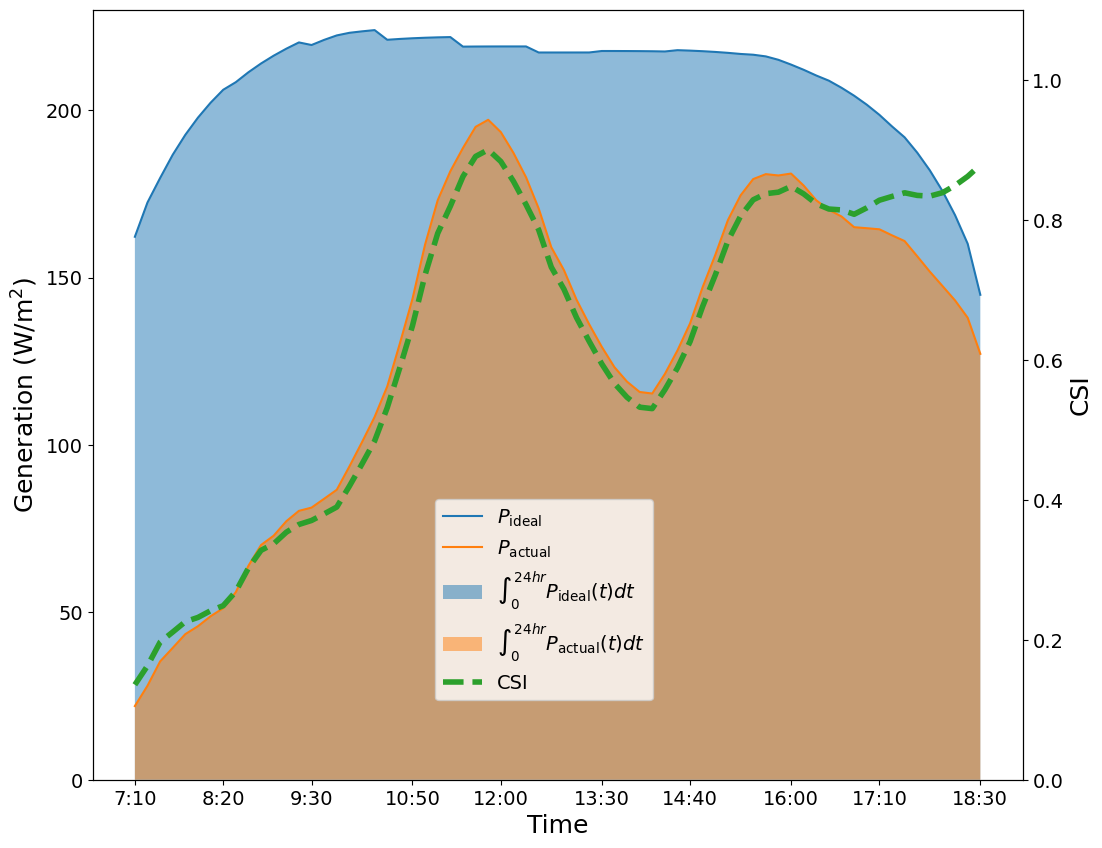

In [23]:
date = slice('2018-12-12T0710', '2018-12-12T1830')
fig, ax = plt.subplots(figsize=(12,10))
data = ds.sel(region='S7', time=date)

# x = [f'{h}:{m:02d}' for h, m in zip(data.time.dt.hour.data, data.time.dt.minute.data)]
x = range(len(data.time))

ax.plot(x, 221 * data.ideal, label = r'$P_\text{ideal}$')
ax.plot(x, 221 * data.actual, label = r'$P_\text{actual}$')

ax.fill_between(x, 221 * data.ideal, alpha=0.5, label = r'$\int_{0}^{24 hr} {P_\text{ideal}(t)}dt$')
ax.fill_between(x, 221 * data.actual, alpha=0.5,label = r'$\int_{0}^{24 hr} {P_\text{actual}(t)}dt$')

ax2 = ax.twinx()
ax2.plot(x, data.actual / data.ideal, c='C2', lw=4, ls='--', label = 'CSI')

# fig.legend(loc='center')
fig.legend(bbox_to_anchor=(0.6,0.4))

ax.set_ylim(0,230)
ax2.set_ylim(0,1.1)

ax.set_ylabel('Generation (W/m$^2$)')
ax2.set_ylabel('CSI')

xticks = np.linspace(0, len(data.time) - 1, 10, dtype=int)
xlabels_all = [f'{data.time.dt.hour.data[i]}:{data.time.dt.minute.data[i]:02d}' for i in xticks]

ax.set_xticks(xticks)
ax.set_xticklabels(xlabels_all)
ax.set_xlabel('Time')
plt.savefig(f'{fig_dir}/csi_example.png')
plt.show()

# Heatmaps

## All Regions

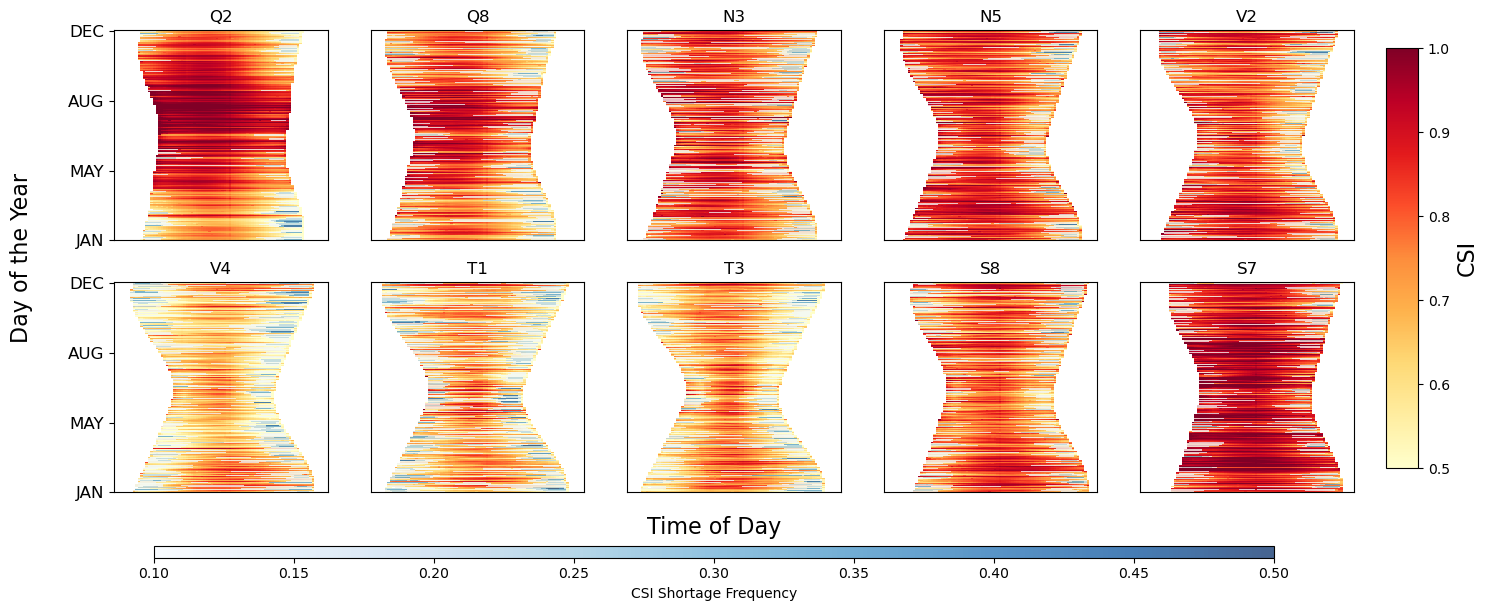

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar_droughts_ax = fig.add_axes([0.15, 0.001, 0.7, 0.02])

# Create the colormaps
cmap = plt.cm.YlOrRd.copy()
# cmap_droughts = mcolors.LinearSegmentedColormap.from_list(
#     'Blues_top_half', plt.cm.Blues(np.linspace(0.7, 0.71, 256))
# )
cmap_droughts = plt.cm.Blues.copy()

cmap.set_bad(color='white')
cmap_droughts.set_bad(color='none')

im = None
im_droughts = None

for idx, reg in enumerate(ds.region):

    data = (ds.sel(region=reg).actual / ds.sel(region=reg).ideal).copy()
    # data = xr.where(data == 0, np.nan, data)
    
    row, col = divmod(idx, 5)
    df = solar_plotting.day_time_df(data)
    df = df.drop(df.columns[49], axis=1)

    # short droughts
    df_droughts = solar_plotting.day_time_mbt(data, threshold = 0.2, drought_length=1)
    df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)
    df_droughts[df_droughts == 0] = np.nan
    # df_droughts[~df_droughts.isna()] = 1
    df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)

    im = ax[row, col].imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0.5, vmax=1, interpolation='none', zorder=0)
    im_droughts = ax[row, col].imshow(df_droughts, aspect="auto", origin="lower", cmap=cmap_droughts, vmin=0.1, vmax=0.5, interpolation='none', zorder=1, alpha=0.75)

    # # Time of day ticks
    # xticks = np.linspace(0, len(df.columns) - 1, 5, dtype=int)
    # xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
    # ax[row, col].set_xticks(xticks)
    # ax[row, col].set_xticklabels(xtick_labels, rotation=25, fontsize=12)
    ax[row, col].set_xticks([])

    if idx in [0, 5]:
        yticks = np.linspace(0, len(df.index) - 1, 4, dtype=int)
        ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b").upper() for j in yticks]
        ax[row, col].set_yticks(yticks)
        ax[row, col].set_yticklabels(ytick_labels, fontsize=12)
    else:
        ax[row, col].set_yticks([])
    # ax[row, col].set_xticks([])

    ax[row, col].set_xlim(4,89)

    ax[row, col].set_title(reg.data)

fig.colorbar(im, cax=cbar_ax).set_label('CSI', fontsize=16)
fig.colorbar(im_droughts, cax=cbar_droughts_ax, orientation='horizontal').set_label('CSI Shortage Frequency')
# fig.colorbar(im_droughts_long, cax=cbar_droughts_long_ax, orientation='horizontal', ticks=[]).set_label('')

fig.text(0.5, 0.04, 'Time of Day', ha='center', fontsize=16)  # global x-label
fig.text(0.06, 0.5, 'Day of the Year', va='center', rotation='vertical', fontsize=16)  # global y-label

# plt.savefig(f'{fig_dir}/CSI-heatmap.png')
plt.show()

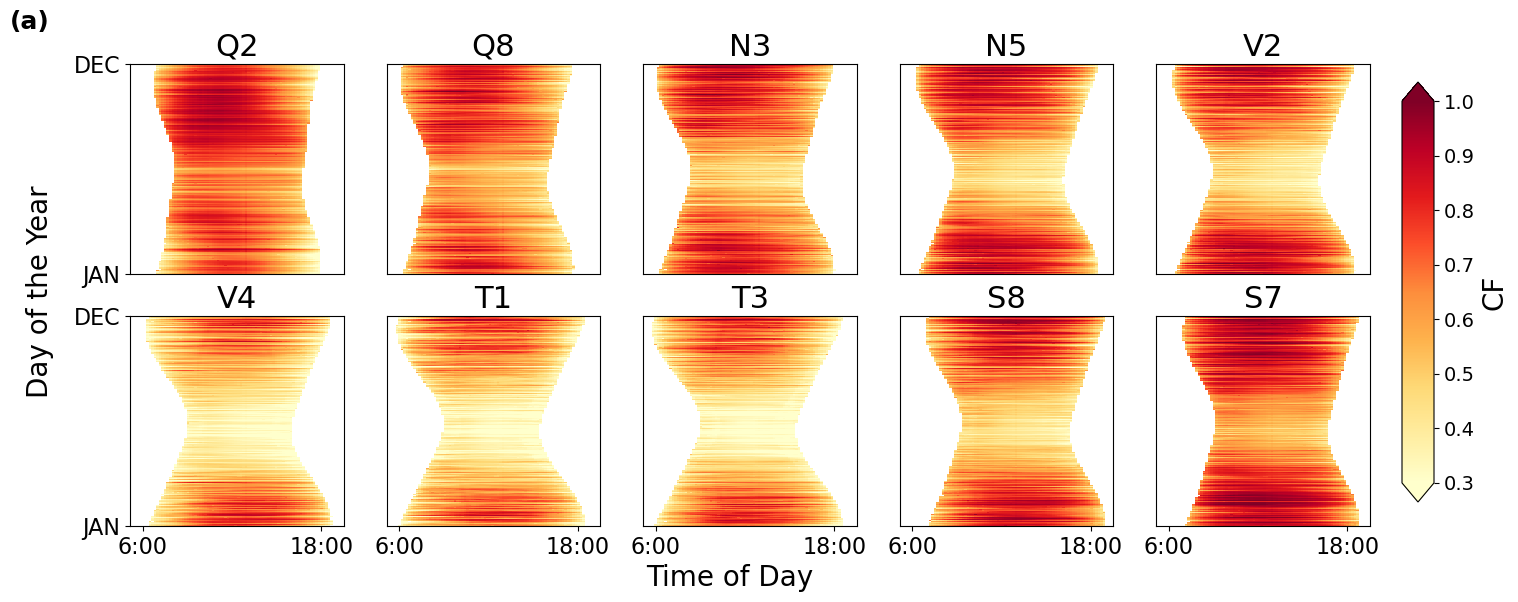

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

# Create the colormaps
cmap = plt.cm.YlOrRd.copy()


cmap.set_bad(color='white')

im = None
im_droughts = None

for idx, reg in enumerate(ds.region):

    data = (ds.sel(region=reg).actual).copy()
    
    row, col = divmod(idx, 5)
    df = solar_plotting.day_time_df(data)
    df = df.drop(df.columns[49], axis=1)

    im = ax[row, col].imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0.3, vmax=1, interpolation='none', zorder=0)


    if idx in [0, 5]:
        yticks = np.linspace(0, len(df.index) - 1, 2, dtype=int)
        ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b").upper() for j in yticks]
        ax[row, col].set_yticks(yticks)
        ax[row, col].set_yticklabels(ytick_labels, fontsize=16)
    else:
        ax[row, col].set_yticks([])

    if idx > 4:
        xticks = [9, 80]
        xtick_labels = [f'{df.columns[i].hour}:{df.columns[i].minute:02}' for i in xticks]
        ax[row, col].set_xticks(xticks)
        ax[row, col].set_xticklabels(xtick_labels, fontsize=16)
    else:
        ax[row, col].set_xticks([])

    ax[row, col].set_xlim(4,89)

    ax[row, col].set_title(reg.data)

fig.colorbar(im, cax=cbar_ax, extend='both').set_label('CF', fontsize=20)

fig.text(0.5, 0.01, 'Time of Day', ha='center', fontsize=20)  # global x-label
fig.text(0.06, 0.5, 'Day of the Year', va='center', rotation='vertical', fontsize=20)  # global y-label

fig.text(0.05, 0.95, '(a)', fontsize=18, fontweight='bold', va='center', ha='left')

plt.savefig(f'{fig_dir}/heatmap-CF.png')
plt.show()

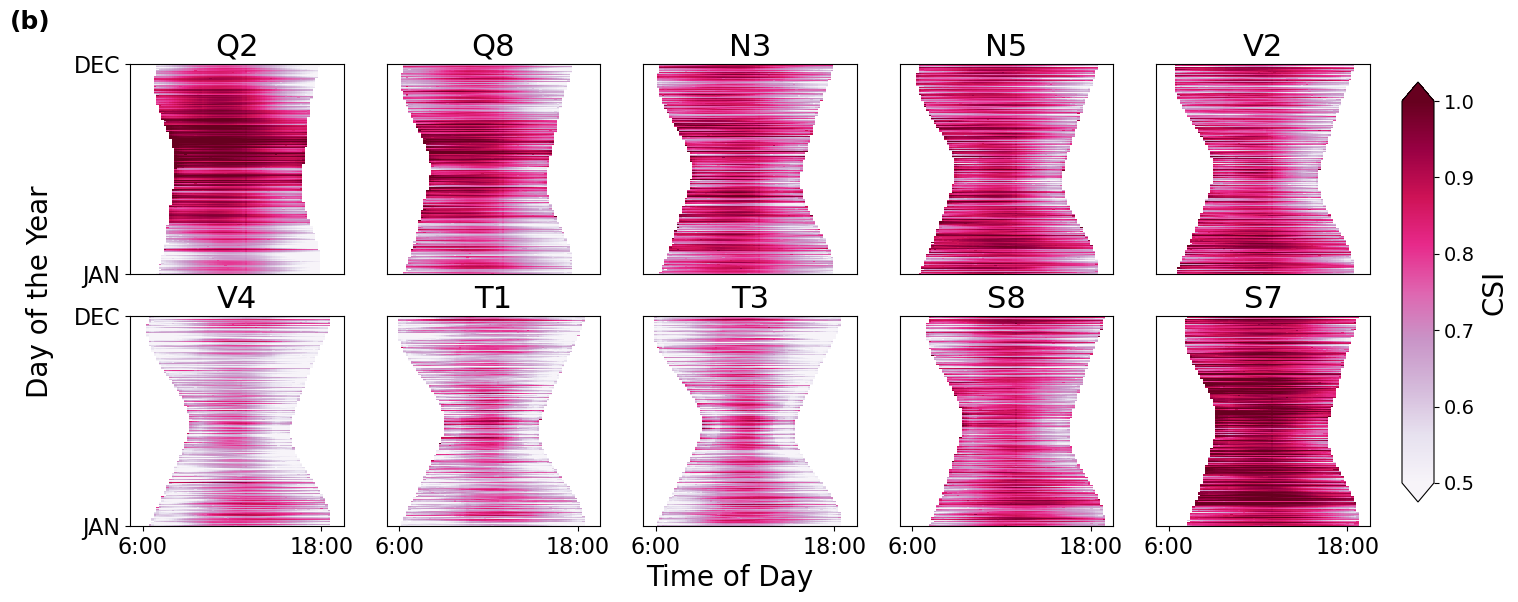

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

# Create the colormaps
cmap = plt.cm.PuRd.copy()
# cmap_droughts = mcolors.LinearSegmentedColormap.from_list(
#     'Blues_top_half', plt.cm.Blues(np.linspace(0.7, 0.71, 256))
# )

cmap.set_bad(color='white')

im = None
im_droughts = None

for idx, reg in enumerate(ds.region):

    data = (ds.sel(region=reg).actual / ds.sel(region=reg).ideal).copy()
    # data = xr.where(data == 0, np.nan, data)
    
    row, col = divmod(idx, 5)
    df = solar_plotting.day_time_df(data)
    df = df.drop(df.columns[49], axis=1)

    im = ax[row, col].imshow(df, aspect="auto", origin="lower", cmap=cmap,
                             vmin=0.5, vmax=1,
                             interpolation='none', zorder=0)

    if idx in [0, 5]:
        yticks = np.linspace(0, len(df.index) - 1, 2, dtype=int)
        ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b").upper() for j in yticks]
        ax[row, col].set_yticks(yticks)
        ax[row, col].set_yticklabels(ytick_labels, fontsize=16)
    else:
        ax[row, col].set_yticks([])

    if idx > 4:
        xticks = [9, 80]
        xtick_labels = [f'{df.columns[i].hour}:{df.columns[i].minute:02}' for i in xticks]
        ax[row, col].set_xticks(xticks)
        ax[row, col].set_xticklabels(xtick_labels, fontsize=16)
    else:
        ax[row, col].set_xticks([])

    ax[row, col].set_xlim(4,89)

    ax[row, col].set_title(reg.data)

fig.colorbar(im, cax=cbar_ax, extend='both').set_label('CSI', fontsize=20)

fig.text(0.5, 0.01, 'Time of Day', ha='center', fontsize=20)  # global x-label
fig.text(0.06, 0.5, 'Day of the Year', va='center', rotation='vertical', fontsize=20)  # global y-label

fig.text(0.05, 0.95, '(b)', fontsize=18, fontweight='bold', va='center', ha='left')

plt.savefig(f'{fig_dir}/heatmap-CSI.png')
plt.show()

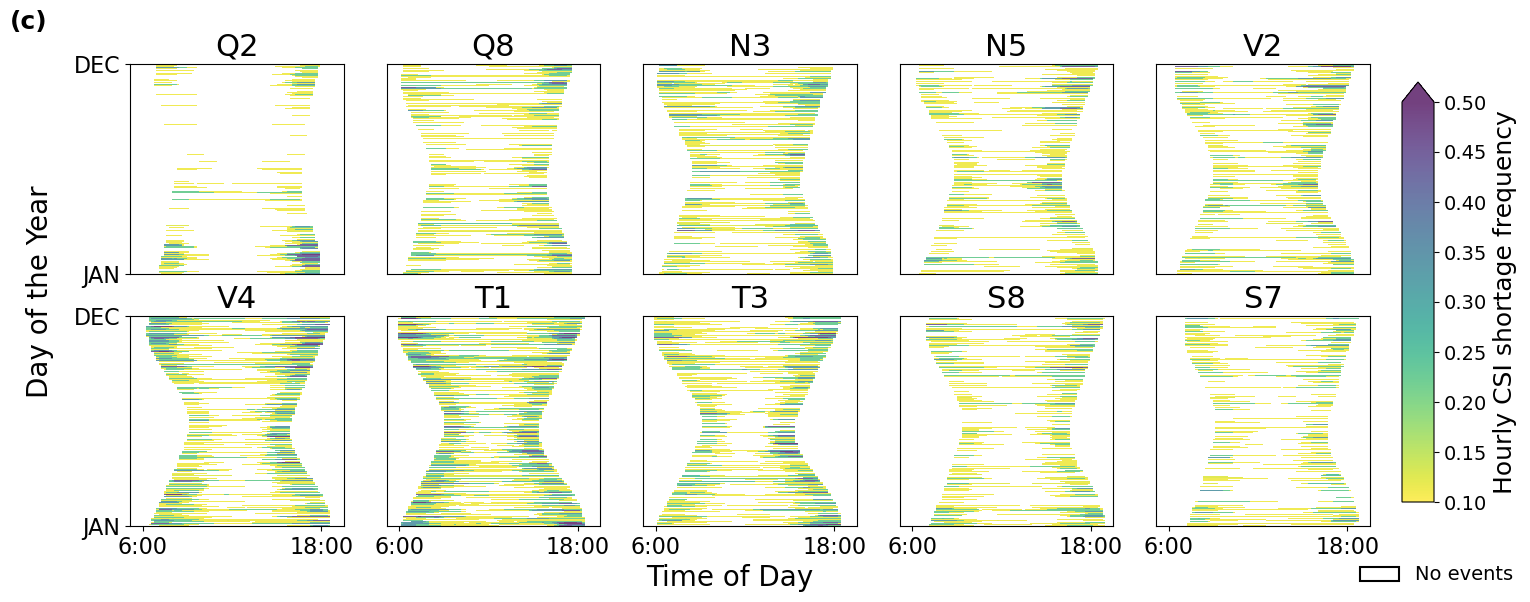

In [8]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

# Create the colormaps
cmap_droughts = plt.cm.viridis_r.copy()

cmap_droughts.set_bad(color='white')

im_droughts = None

for idx, reg in enumerate(ds.region):

    data = (ds.sel(region=reg).actual / ds.sel(region=reg).ideal).copy()
    # data = xr.where(data == 0, np.nan, data)
    
    row, col = divmod(idx, 5)

    # short droughts
    df_droughts = solar_plotting.day_time_mbt(data, threshold = 0.25, drought_length=1)
    df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)
    df_droughts[df_droughts == 0] = np.nan

   
    im_droughts = ax[row, col].imshow(df_droughts, aspect="auto", origin="lower",
                                      cmap=cmap_droughts,
                                      vmin=0.1, vmax=0.5,
                                      interpolation='none', zorder=1, alpha=0.75)

    # # Time of day ticks
    # xticks = np.linspace(0, len(df.columns) - 1, 5, dtype=int)
    # xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
    # ax[row, col].set_xticks(xticks)
    # ax[row, col].set_xticklabels(xtick_labels, rotation=25, fontsize=12)

    if idx in [0, 5]:
        yticks = np.linspace(0, len(df_droughts.index) - 1, 2, dtype=int)
        ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df_droughts.index[j]) - 1)).strftime("%b").upper() for j in yticks]
        ax[row, col].set_yticks(yticks)
        ax[row, col].set_yticklabels(ytick_labels, fontsize=16)
    else:
        ax[row, col].set_yticks([])

    if idx > 4:
        xticks = [9, 80]
        xtick_labels = [f'{df_droughts.columns[i].hour}:{df_droughts.columns[i].minute:02}' for i in xticks]
        ax[row, col].set_xticks(xticks)
        ax[row, col].set_xticklabels(xtick_labels, fontsize=16)
    else:
        ax[row, col].set_xticks([])

    ax[row, col].set_xlim(4,89)

    ax[row, col].set_title(reg.data)

cbar = fig.colorbar(im_droughts, cax=cbar_ax, orientation='vertical', extend='max')
cbar.set_label('Hourly CSI shortage frequency')

# Create a custom legend handle for NaNs
nan_patch = Patch(
    facecolor="white",
    edgecolor="black",   # visible border
    linewidth=1.5,
    label="No events"
)
fig.legend(handles=[nan_patch], loc="lower right", frameon=False)
# fig.colorbar(im_droughts_long, cax=cbar_droughts_long_ax, orientation='horizontal', ticks=[]).set_label('')

fig.text(0.5, 0.01, 'Time of Day', ha='center', fontsize=20)  # global x-label
fig.text(0.06, 0.5, 'Day of the Year', va='center', rotation='vertical', fontsize=20)  # global y-label

fig.text(0.05, 0.95, '(c)', fontsize=18, fontweight='bold', va='center', ha='left')

plt.savefig(f'{fig_dir}/heatmap-shortages.png')
plt.show()

## Single Region

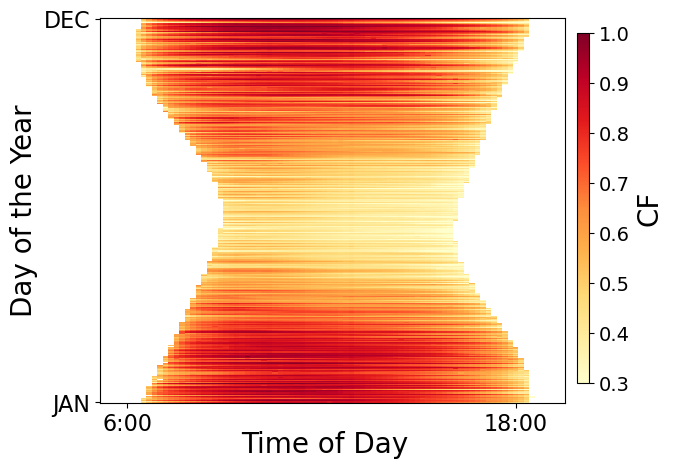

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

# Create the colormaps
cmap = plt.cm.YlOrRd.copy()
cmap.set_bad(color='white')

im = None
im_droughts = None

data = (ds.sel(region='V2').actual).copy()

df = solar_plotting.day_time_df(data)
df = df.drop(df.columns[49], axis=1)

im = ax.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0.3, vmax=1, interpolation='none', zorder=0)


yticks = np.linspace(0, len(df.index) - 1, 2, dtype=int)
ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b").upper() for j in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize=16)

xticks = [9, 80]
xtick_labels = [f'{df.columns[i].hour}:{df.columns[i].minute:02}' for i in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, fontsize=16)

ax.set_xlim(4,89)
ax.set_ylabel('Day of the Year', fontsize=20)

fig.colorbar(im, cax=cbar_ax).set_label('CF', fontsize=20)

fig.text(0.5, 0.01, 'Time of Day', ha='center', fontsize=20)  # global x-label
plt.show()

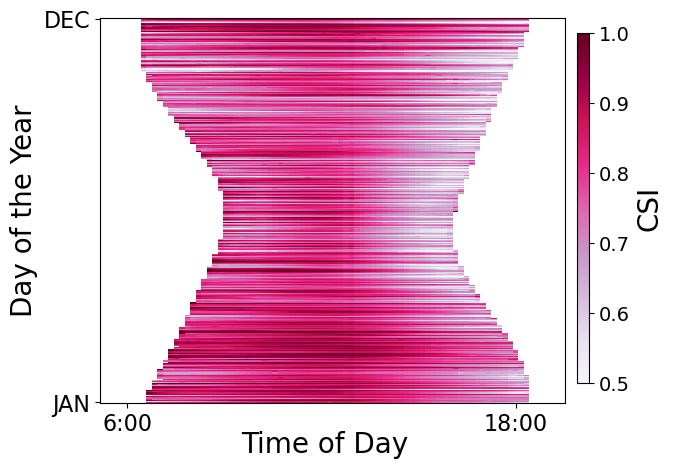

In [151]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

cmap = plt.cm.PuRd.copy()

cmap.set_bad(color='white')

im = None
im_droughts = None

data = (ds.sel(region='V2').actual / ds.sel(region='V2').ideal).copy()

df = solar_plotting.day_time_df(data)
df = df.drop(df.columns[49], axis=1)

im = ax.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0.5, vmax=1, interpolation='none', zorder=0)


yticks = np.linspace(0, len(df.index) - 1, 2, dtype=int)
ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b").upper() for j in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize=16)


xticks = [9, 80]
xtick_labels = [f'{df.columns[i].hour}:{df.columns[i].minute:02}' for i in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, fontsize=16)

ax.set_xlim(4,89)

ax.set_ylabel('Day of the Year', fontsize=20)

fig.colorbar(im, cax=cbar_ax).set_label('CSI', fontsize=20)

fig.text(0.5, 0.01, 'Time of Day', ha='center', fontsize=20)  # global x-label

# plt.savefig(f'{fig_dir}/heatmap-CSI.png')
plt.show()

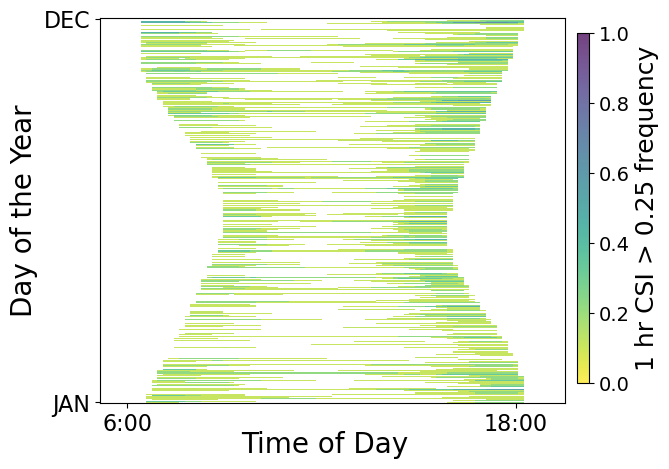

In [153]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

# Create the colormaps
cmap_droughts = plt.cm.viridis_r.copy()

cmap_droughts.set_bad(color='white')

im_droughts = None

data = (ds.sel(region='V2').actual / ds.sel(region='V2').ideal).copy()
# data = xr.where(data == 0, np.nan, data)

# short droughts
df_droughts = solar_plotting.day_time_mbt(data, threshold = 0.25, drought_length=1)
df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)
df_droughts[df_droughts == 0] = np.nan
# df_droughts[~df_droughts.isna()] = 1
df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)


im_droughts = ax.imshow(df_droughts, aspect="auto", origin="lower",
                                  cmap=cmap_droughts, vmin=0, vmax=1,
                                  interpolation='none', zorder=1, alpha=0.75)



yticks = np.linspace(0, len(df.index) - 1, 2, dtype=int)
ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b").upper() for j in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize=16)


xticks = [9, 80]
xtick_labels = [f'{df.columns[i].hour}:{df.columns[i].minute:02}' for i in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, fontsize=16)

ax.set_xlim(4,89)

ax.set_ylabel('Day of the Year', fontsize=20)


fig.colorbar(im_droughts, cax=cbar_ax, orientation='vertical').set_label('1 hr CSI > 0.25 frequency')
# fig.colorbar(im_droughts_long, cax=cbar_droughts_long_ax, orientation='horizontal', ticks=[]).set_label('')

fig.text(0.5, 0.01, 'Time of Day', ha='center', fontsize=20)  # global x-label

plt.show()

## Combine figures

In [9]:
from PIL import Image

fig1 = Image.open(f'{fig_dir}/heatmap-CF.png')
fig2 = Image.open(f'{fig_dir}/heatmap-CSI.png')
fig3 = Image.open(f'{fig_dir}/heatmap-shortages.png')

# Combine vertically
max_width = max(fig1.width, fig2.width, fig3.width)
total_height = fig1.height + fig2.height + fig3.height

combined = Image.new('RGB', (max_width, total_height))
combined.paste(fig1, (0, 0))
combined.paste(fig2, (0, fig1.height))
combined.paste(fig3, (0, fig1.height + fig2.height))

combined.save(f'{fig_dir}/combined_heatmaps.png')

# Daily Shortage Lineplots

Limit analysis to Apr-Aug, i.e. shortest days as per below plot

Text(0, 0.5, 'Mean Monthly Insolation')

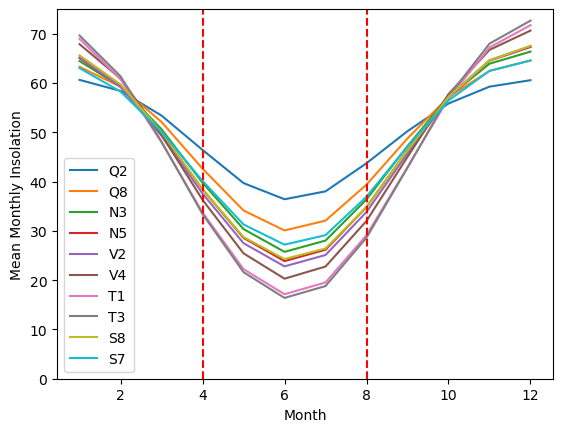

In [11]:
for reg in ds.region:
    data = ds.sel(region=reg)
    ideal_day = data.ideal.resample(time='1D').sum()
    month = ideal_day.groupby('time.month').mean(dim='time')

    plt.plot(np.linspace(1,12,12), month, label=reg.data)
plt.axvline(4, color='r', linestyle='--')
plt.axvline(8, color='r', linestyle='--')
plt.ylim(0,75)
plt.legend()
plt.xlabel('Month')
plt.ylabel('Mean Monthly Insolation')


## Severity Threshold

For a given threshold of how severe a day needs to be to count as a drought, what is the frequency of events of different durations

### Mean below threshold

In [16]:
ds['actual'].sel(region=reg).integrate(coord='time')

<xarray.DataArray 'actual' ()> Size: 8B
array(nan)
Coordinates:
    region   <U2 8B 'S7'

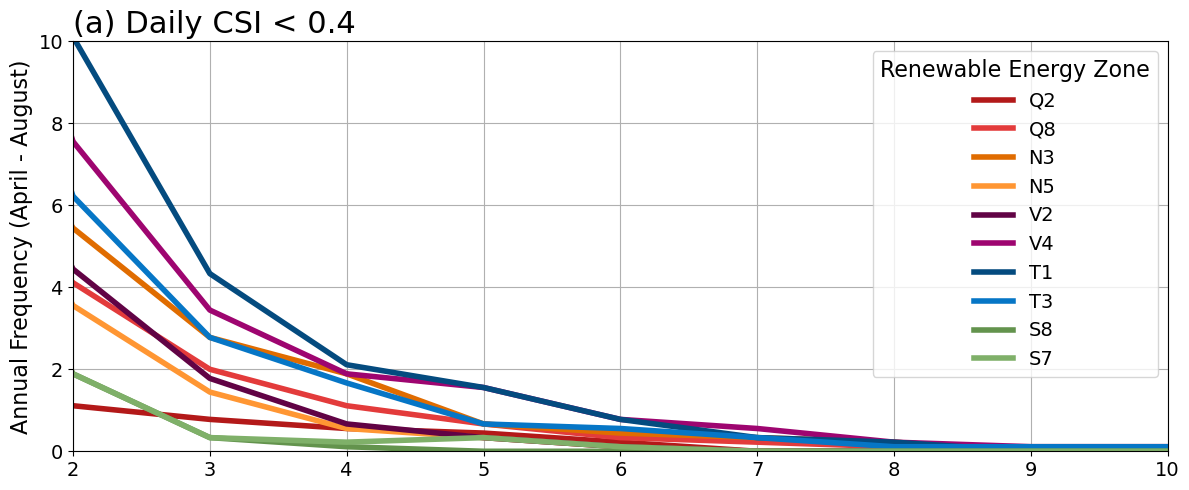

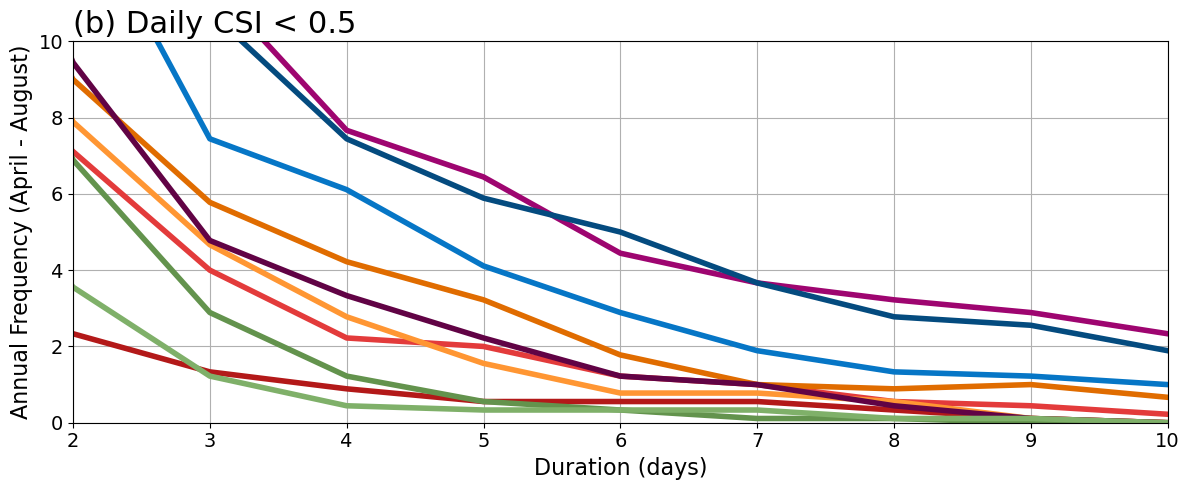

In [38]:
# Cumulative durations, i.e. a drought of X length OR LONGER

# rez_colours = {
#     'Q2':'#B31919',
#     'Q8': '#E33B3B',
#     'N3': '#E06C00',
#     'N5': '#FF9633',
#     'V2': '#610345',
#     'V4': '#9E0570',
#     'T1': '#044B7F',
#     'T3': '#0676C6',
#     'S8': '#63934D',
#     'S7': '#7FB069'
# }
for T in np.linspace(0.4, 0.5, 2):
    fig, ax = plt.subplots(figsize=(12,5))
    for reg in ds.region:
        # print("Region: ", reg.data)
    
        daily_actual = ds['actual'].sel(region=reg).resample(time='1D').map(
            lambda x: x.fillna(0).integrate(coord='time')
        )
        daily_ideal = ds['ideal'].sel(region=reg).resample(time='1D').map(
            lambda x: x.fillna(0).integrate(coord='time')
        )
    
        daily_CSI = daily_actual / daily_ideal
        
        dur, freq = solar_plotting.daily_mbt_cumulative(
            daily_CSI.where(daily_CSI.time.dt.month.isin([4,5,6,7,8]), drop=True),
            threshold=T,
        )
        # freq = [np.nan if x == 0 else x for x in freq]
        ax.plot(dur, freq, label=reg.data, lw=4, color=rez_colours[reg.item()])
        # for d, f in zip(dur, freq):
            # print("duration: ", d, ". frequency: ", f)
            
    ax.grid(True)
    
    ax.set_ylabel('Annual Frequency (April - August)', fontsize=16)
    
    ax.set_ylim(0,10)
    ax.set_xlim(2,10)

    

    if T == 0.4:
        ax.legend(fontsize=14, title='Renewable Energy Zone', title_fontsize=16)
        ax.set_title('(a) Daily CSI < 0.4' , loc='left')
    else:
        ax.set_title('(b) Daily CSI < 0.5', loc='left')
        ax.set_xlabel('Duration (days)', fontsize=16)
    # ax.set_title(f'CSI Threshold = {T:.2f}', fontsize=20)
    plt.tight_layout()
    plt.savefig(f'{fig_dir}/intensity_threshold_{T}.png')
    plt.show()

## Duration Threshold

For a given duration, what is the frequency of events that have different severities

### Load Duration Curves

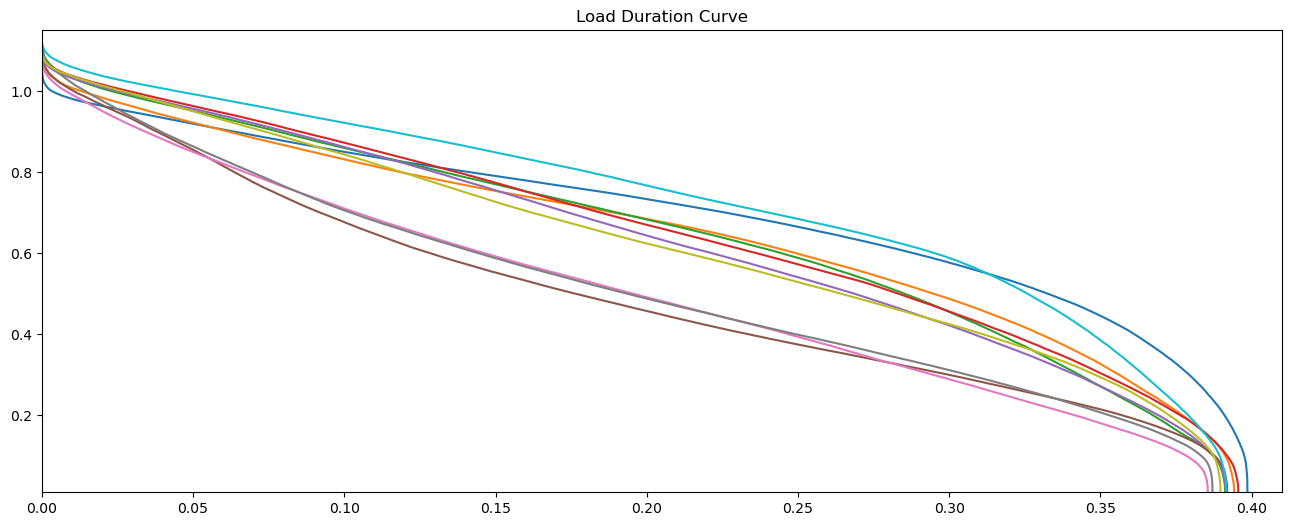

In [14]:
# It is helpful to first look at the load duration durve to assess these results

fig, ax = plt.subplots(figsize=(16,6))

for reg in ds.region:

    data = ds.actual.sel(region=reg).copy()
    
    
    full_time = pd.date_range(start=ds.time.min().values,
                          end=ds.time.max().values,
                          freq='10min')
    data_filled = data.reindex(time=full_time).fillna(0)
    
    ax.plot(np.linspace(0, 1, len(data_filled)), np.sort(data_filled)[::-1])
    ax.set_xlim(0, 0.41)
    ax.set_ylim(0.01, 1.15)
    ax.set_title('Load Duration Curve')

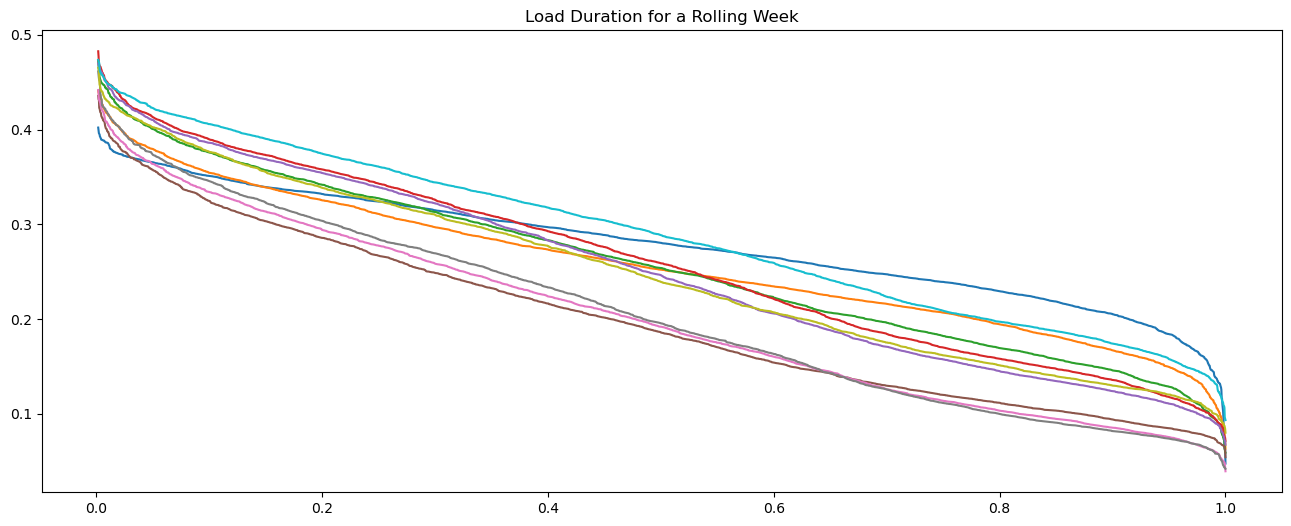

In [15]:
fig, ax = plt.subplots(figsize=(16,6))

for reg in ds.region:

    data = ds.actual.sel(region=reg).copy()
    
    
    full_time = pd.date_range(start=ds.time.min().values,
                          end=ds.time.max().values,
                          freq='10min')
    data_filled = data.reindex(time=full_time).fillna(0)
    daily = data_filled.resample(time='1D').mean()
    rolling_week = daily.rolling(time=7, center=False).mean()
    
    ax.plot(np.linspace(0, 1, len(rolling_week)), np.sort(rolling_week)[::-1])
    ax.set_title('Load Duration for a Rolling Week')

### Weekly Droughts

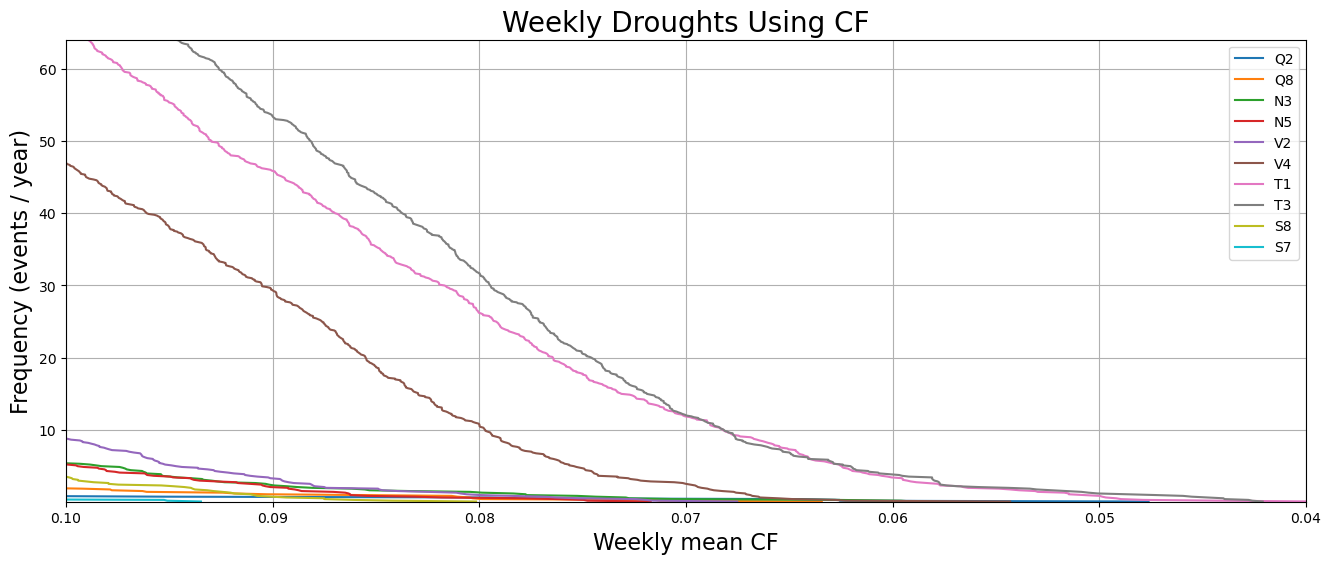

In [16]:
fig, ax = plt.subplots(figsize=(16,6))

for reg in ds.region:

    data = ds.actual.sel(region=reg).copy()
    
    
    full_time = pd.date_range(start=ds.time.min().values,
                          end=ds.time.max().values,
                          freq='10min')
    data_filled = data.reindex(time=full_time).fillna(0)
    daily = data_filled.resample(time='1D').mean()
    rolling_week = daily.rolling(time=7, center=False).mean()
    
    sorted_vals = np.sort(rolling_week)
    cdf = np.arange(1, len(sorted_vals)+1) / len(np.unique(ds.time.dt.year))
    
    ax.plot(sorted_vals, cdf, label = reg.data)
ax.set_xlim(0.1,0.04)
# ax.set_ylim(0,20)
ax.grid(True)
ax.set_xlabel('Weekly mean CF', fontsize=16)
ax.set_ylabel('Frequency (events / year)', fontsize=16)
# ax.set_yscale('log', base=2)
# ax.yaxis.set_major_locator(LogLocator(base=2.0))
# ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
# ax.set_yticks([0.125, 0.5, 2, 8, 32])
ax.set_ylim(0.08,64)
ax.set_title('Weekly Droughts Using CF', fontsize=20)

ax.legend()

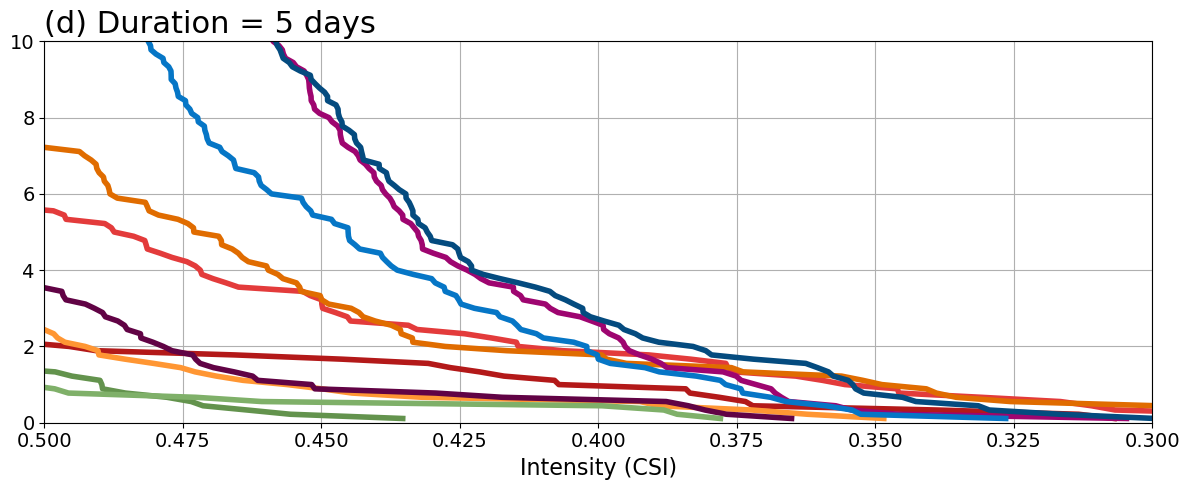

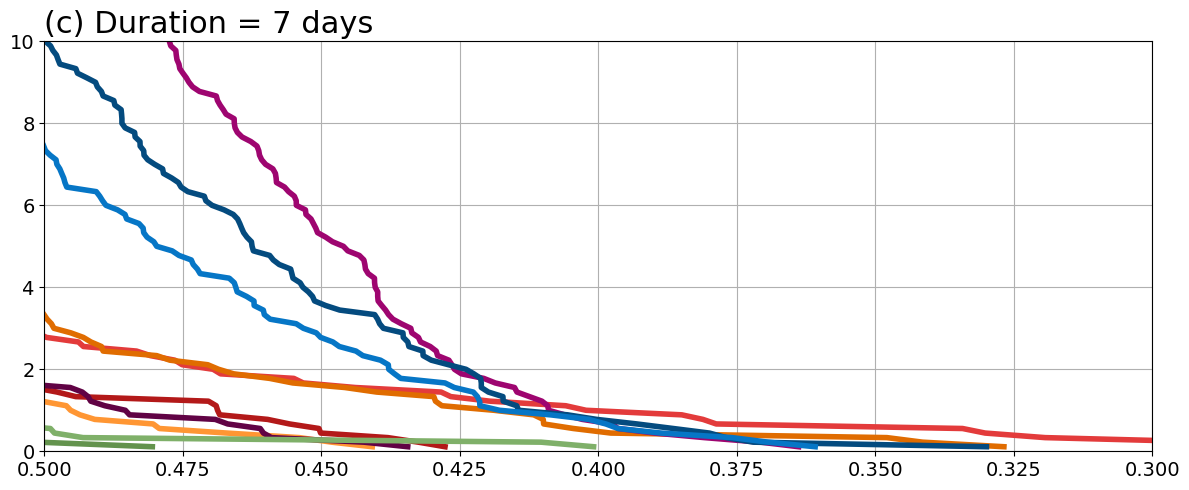

In [39]:
for D in range(5,8,2):
    fig, ax = plt.subplots(figsize=(12,5))
    
    for reg in ds.region:
        
        data = ds.sel(region=reg).copy()
        full_time = pd.date_range(start=ds.time.min().values,
                              end=ds.time.max().values,
                              freq='10min')
        data_filled = data.reindex(time=full_time).fillna(0)
    
        daily_actual = data_filled.actual.resample(time='1D').sum()
        daily_ideal = data_filled.ideal.resample(time='1D').sum()
        daily_CSI = daily_actual / daily_ideal
    
        rolling_dur = daily_CSI.rolling(time=D, center=False).mean()
        rolling_dur_cold_months = rolling_dur.where(rolling_dur.time.dt.month.isin([4,5,6,7,8]), drop=True)
        
        sorted_vals = np.sort(rolling_dur_cold_months)
        cdf = np.arange(1, len(sorted_vals)+1) / len(np.unique(ds.time.dt.year))
        
        ax.plot(sorted_vals, cdf, label = reg.data, lw=4, color=rez_colours[reg.data.item()])
    ax.set_xlim(0.5,0.3)
    ax.grid(True)
    
    # ax.set_ylabel('Frequency (events / yr)', fontsize=16)
    # ax.set_yscale('log', base=2)
    # ax.yaxis.set_major_locator(LogLocator(base=2.0))
    # ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
    # ax.set_yticks([0.125, 0.5, 2, 8, 32])
    ax.set_ylim(0.0,10)
    # ax.set_title('Weekly Droughts Using CSI', fontsize=20)
    # ax.legend(fontsize=14)

    if D == 7:
        ax.set_title('(c) Duration = 7 days', loc='left')
    else:
        ax.set_title('(d) Duration = 5 days', loc='left')
        ax.set_xlabel(f'Intensity (CSI)', fontsize=16)

    plt.tight_layout()
    plt.savefig(f'{fig_dir}/duration_threshold_{D}.png')
    plt.show()

In [42]:
fig1 = Image.open(f'{fig_dir}/intensity_threshold_0.4.png')
fig2 = Image.open(f'{fig_dir}/intensity_threshold_0.5.png')
fig3 = Image.open(f'{fig_dir}/duration_threshold_7.png')
fig4 = Image.open(f'{fig_dir}/duration_threshold_5.png')

# Combine 2 x 2 grid
total_width = fig1.width + fig3.width
total_height = fig1.height + fig2.height

combined = Image.new('RGB', (total_width, total_height))
combined.paste(fig1, (0, 0))
combined.paste(fig2, (0, fig1.height))
combined.paste(fig3, (fig1.width, 0))
combined.paste(fig4, (fig1.width, fig1.height))

combined.save(f'{fig_dir}/combined_lineplots.png')

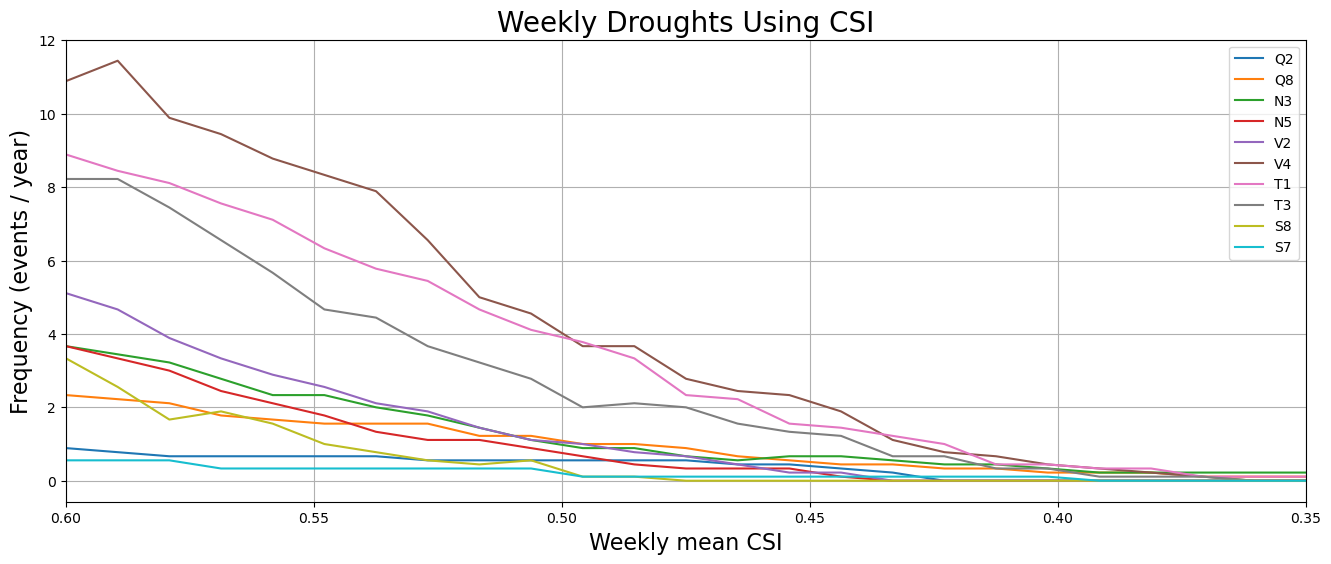

In [18]:
fig, ax = plt.subplots(figsize=(16,6))

for reg in ds.region:
    
    data = ds.sel(region=reg).copy()
    full_time = pd.date_range(start=ds.time.min().values,
                          end=ds.time.max().values,
                          freq='10min')
    data_filled = data.reindex(time=full_time).fillna(0)

    daily_actual = data_filled.actual.resample(time='1D').sum()
    daily_ideal = data_filled.ideal.resample(time='1D').sum()
    daily_CSI = daily_actual / daily_ideal

    rolling_week = daily_CSI.rolling(time=7, center=True).mean()
    rolling_week_cold_months = rolling_week.where(rolling_week.time.dt.month.isin([4,5,6,7,8]), drop=True)


    # Applies the same methodology as in the intensity defined droughts.
    # Finds the worst events first (i.e. longest or most intense) counts them, and then removes them so there is
    # no double counting
    n_years = len(np.unique(rolling_week_cold_months.time.dt.year))
    counted_droughts = xr.zeros_like(rolling_week_cold_months, dtype=bool)
    n_droughts = []
    thresholds = np.linspace (0.35, 0.6, 25)
    for threshold in thresholds:
        drought_flags = (rolling_week_cold_months < threshold)
        drought_starts = drought_flags & (~drought_flags.shift(time=1, fill_value=False))
        n_droughts.append(drought_starts.sum().item() / n_years)
        full_drought_mask = drought_starts.rolling(time=7, center=True, min_periods=1).max().astype(bool)
        counted_droughts = counted_droughts | full_drought_mask
    
    ax.plot(thresholds, n_droughts, label = reg.data)
ax.set_xlim(0.6,0.35)
ax.grid(True)
ax.set_xlabel('Weekly mean CSI', fontsize=16)
ax.set_ylabel('Frequency (events / year)', fontsize=16)
# ax.set_yscale('log', base=2)
# ax.yaxis.set_major_locator(LogLocator(base=2.0))
# ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
# ax.set_yticks([0.125, 0.5, 2, 8, 32])
# ax.set_ylim(0.0,10)
ax.set_title('Weekly Droughts Using CSI', fontsize=20)

ax.legend()

# Correlations

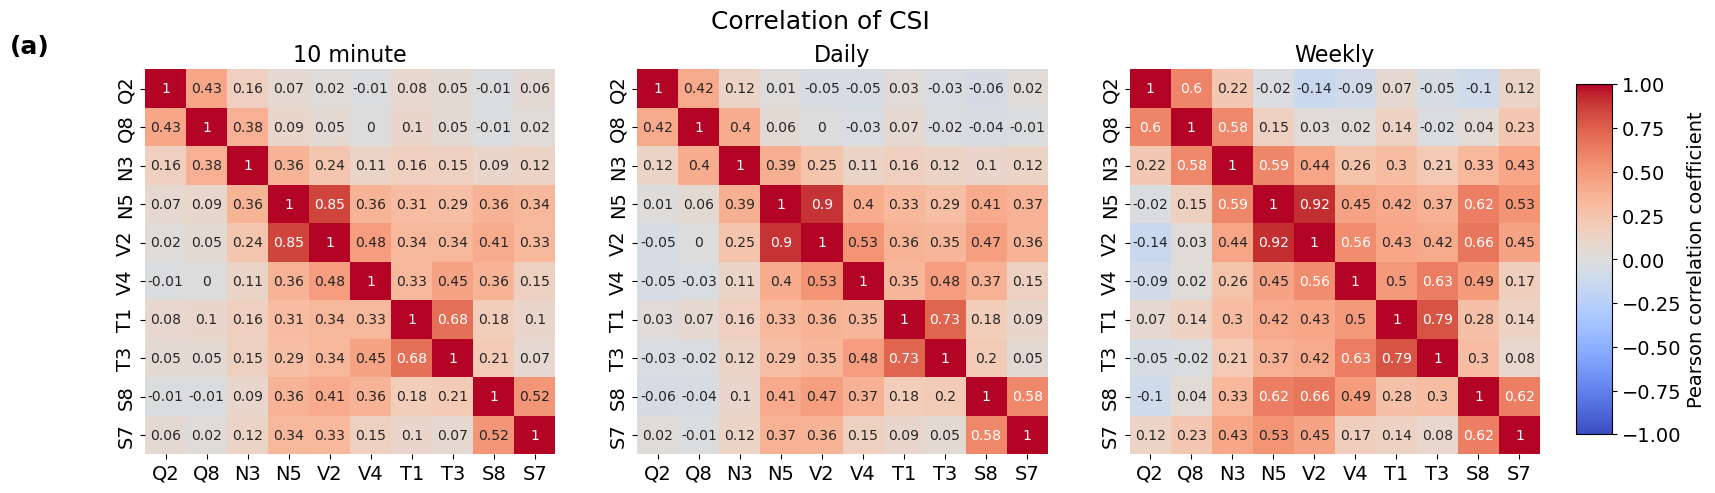

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

csi= ds.actual / ds.ideal
corr_df_minutely = regional_correlations(csi)

csi_daily = ds.actual.resample(time='1D').sum() / ds.ideal.resample(time='1D').sum()

corr_df_daily = regional_correlations(csi_daily)
corr_df_weekly = regional_correlations(csi_daily.rolling(time=7).mean())

sns.heatmap(corr_df_minutely, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0], cbar=False)
sns.heatmap(corr_df_daily, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1], cbar=False)
_hm = sns.heatmap(corr_df_weekly, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[2], cbar=False)

axes[0].set_title('10 minute', fontsize=16)
axes[1].set_title('Daily', fontsize=16)
axes[2].set_title('Weekly', fontsize=16)

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # adjust as needed
fig.colorbar(_hm.get_children()[0], cax=cbar_ax, orientation='vertical')
cbar_ax.set_ylabel('Pearson correlation coefficient', fontsize=14)

fig.text(0.05, 0.95, '(a)', fontsize=18, fontweight='bold', va='top', ha='left')

fig.suptitle('Correlation of CSI', fontsize=18, y=1)
# plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plt.savefig(f'{fig_dir}/regional_correlation.png')
plt.show()

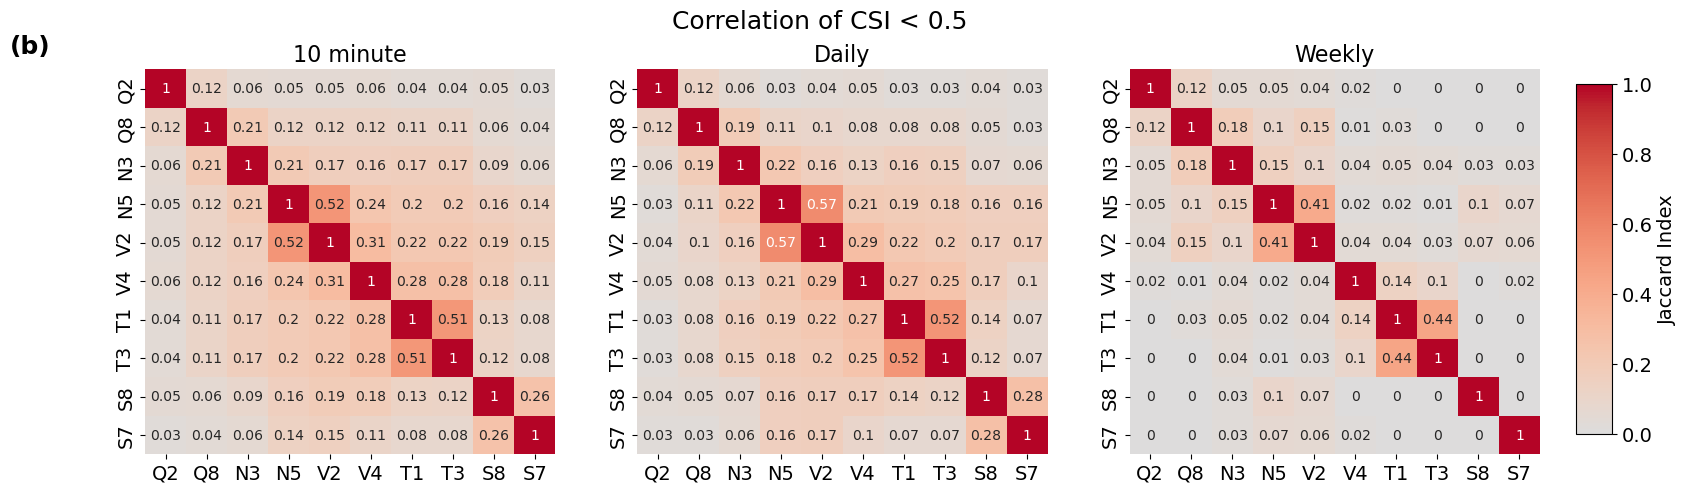

In [6]:
import matplotlib.colors as mcolors

T=0.5
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

# take the top half of coolwarm
coolwarm_top = mcolors.LinearSegmentedColormap.from_list(
    "coolwarm_top", 
    plt.cm.coolwarm(np.linspace(0.5, 1, 256))
)


csi = ds.actual / ds.ideal
csi_cold_months = csi.where(csi.time.dt.month.isin([4,5,6,7,8]), drop=True)
minute_bin = xr.where(csi_cold_months < T, 1, 0)

csi_daily = ds.actual.resample(time='1D').sum() / ds.ideal.resample(time='1D').sum()
csi_daily_cold_months = csi_daily.where(csi_daily.time.dt.month.isin([4,5,6,7,8]), drop=True)
day_bin = xr.where(csi_daily_cold_months < T, 1, 0)

csi_weekly = csi_daily_cold_months.rolling(time=7).mean()
week_bin = xr.where(csi_weekly < T, 1, 0)

corr_df_minutely = jaccard_matrix(minute_bin)
corr_df_daily = jaccard_matrix(day_bin)
corr_df_weekly = jaccard_matrix(week_bin)

sns.heatmap(corr_df_minutely, annot=True, cmap=coolwarm_top, vmin=0, vmax=1, ax=axes[0], cbar=False)
sns.heatmap(corr_df_daily, annot=True, cmap=coolwarm_top, vmin=0, vmax=1, ax=axes[1], cbar=False)
_hm = sns.heatmap(corr_df_weekly, annot=True, cmap=coolwarm_top, vmin=0, vmax=1, ax=axes[2], cbar=False)

axes[0].set_title('10 minute', fontsize=16)
axes[1].set_title('Daily', fontsize=16)
axes[2].set_title('Weekly', fontsize=16)

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(_hm.get_children()[0], cax=cbar_ax, orientation='vertical')
cbar_ax.set_ylabel('Jaccard Index', fontsize=14)

fig.text(0.05, 0.95, '(b)', fontsize=18, fontweight='bold', va='top', ha='left')

fig.suptitle(f'Correlation of CSI < {T}', fontsize=18, y=1)

plt.savefig(f'{fig_dir}/drought_correlation.png')
plt.show()

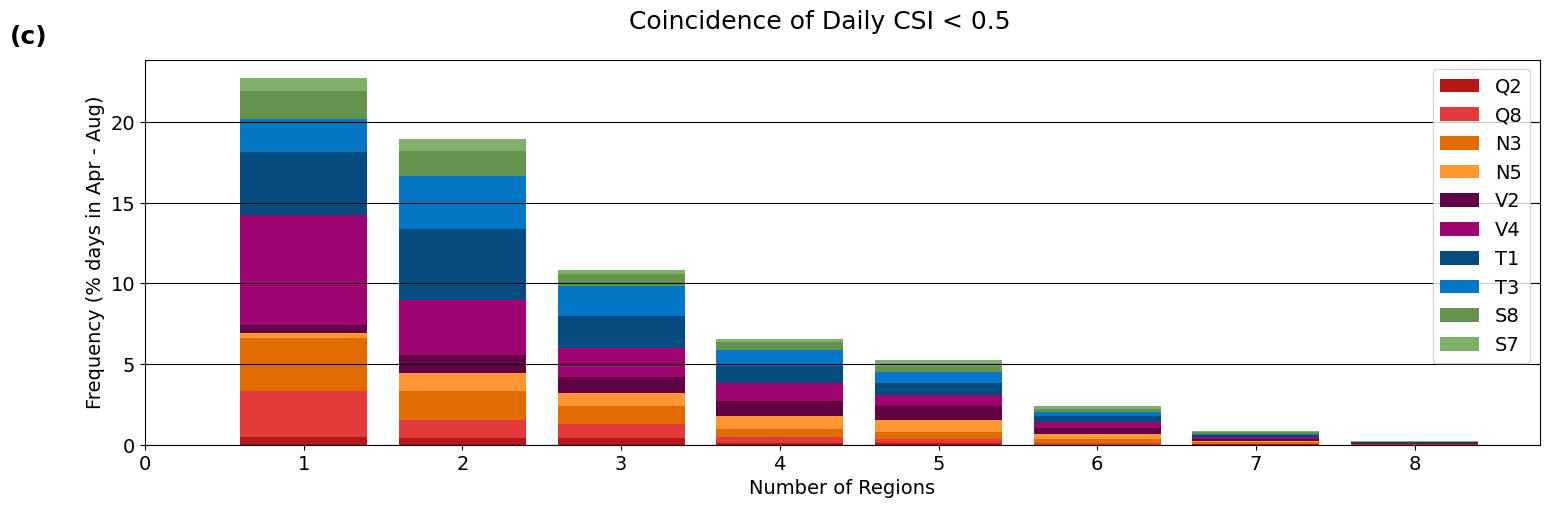

In [40]:
T=0.5
fig, axes = plt.subplots(figsize=(18,5))

csi_daily = ds.actual.resample(time='1D').sum() / ds.ideal.resample(time='1D').sum()
daily_droughts = xr.where(csi_daily < T, 1, 0)
daily_droughts_cold_months = daily_droughts.where(daily_droughts.time.dt.month.isin([4,5,6,7,8]), drop=True)

total_daily_droughts = daily_droughts_cold_months.sum(dim='region')

# num_zeros = total_daily_droughts.where(total_daily_droughts == 0, drop=True).shape[0] / len(np.unique(ds.time.dt.year))
# plt.bar(0, num_zeros, color='white', edgecolor='black')

# For each number of coincident droughts, find the number of times that each region
# contributes to that cumulative total
bottom = np.zeros(8)
for reg in ds.region:
    reg_droughts = []
    for num_regs in range(1,9):
        num_reg_droughts = xr.where((total_daily_droughts == num_regs) & (daily_droughts_cold_months.sel(region=reg) == 1), 1, 0).sum().data
        reg_droughts.append(100 * num_reg_droughts  / (daily_droughts_cold_months.time.shape[0] * num_regs))
    plt.bar(range(1,9), reg_droughts, bottom=bottom, label=reg.data, color=rez_colours[reg.data.item()])
    bottom += reg_droughts
    
plt.xticks(range(0,9))
plt.legend()
plt.xlabel('Number of Regions', fontsize=14)
plt.ylabel('Frequency (% days in Apr - Aug)', fontsize=14)

fig.text(0.05, 0.95, '(c)', fontsize=18, fontweight='bold', va='top', ha='left')
fig.suptitle(f'Coincidence of Daily CSI < {T}', fontsize=18)
plt.grid(color='black', axis='y')

plt.savefig(f'{fig_dir}/coincident_regions.png')
plt.show()

In [41]:
from PIL import Image

fig1 = Image.open(f'{fig_dir}/regional_correlation.png')
fig2 = Image.open(f'{fig_dir}/drought_correlation.png')
fig3 = Image.open(f'{fig_dir}/coincident_regions.png')


# Combine vertically
total_width = max(fig1.width, fig2.width, fig3.width)
total_height = fig1.height + fig2.height + fig3.height

combined = Image.new('RGB', (total_width, total_height))
combined.paste(fig1, (0, 0))
combined.paste(fig2, (0, fig1.height))
combined.paste(fig3, (0, fig1.height + fig2.height))

combined.save(f'{fig_dir}/combined_coincidence.png')

# Case Study

## Finding the Worst Events

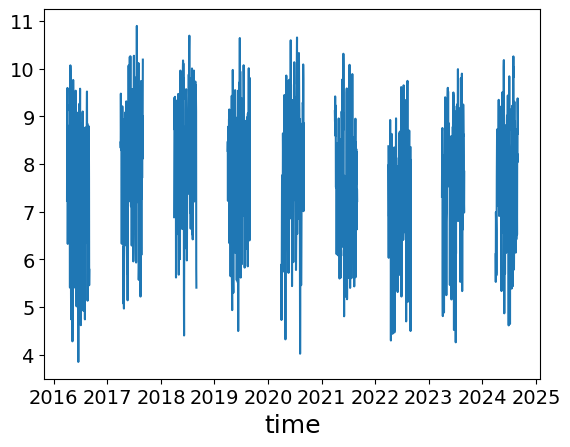

In [7]:
daily_actual = ds.actual.resample(time='1D').sum(skipna=True)
daily_ideal = ds.ideal.resample(time='1D').sum(skipna=True)
daily_CSI = daily_actual / daily_ideal
all_regions = daily_CSI.sum(dim='region', skipna=True)

all_regions_cold = all_regions.where(all_regions.time.dt.month.isin([4,5,6,7,8]))

all_regions_cold = all_regions_cold.where(all_regions_cold != 0, drop=True)
all_regions_cold.plot()

In [7]:
all_rolling = all_regions_cold.rolling(time=7, center=False).mean()
for combined_CSI in np.sort(all_rolling)[:20]:
    print(all_rolling.where(all_rolling == combined_CSI, drop=True).data / 10)
    print(all_rolling.where(all_rolling == combined_CSI, drop=True).time.data)

[0.524493]
['2016-06-23T00:00:00.000000000']
[0.52705031]
['2016-06-22T00:00:00.000000000']
[0.55281058]
['2016-06-21T00:00:00.000000000']
[0.56662801]
['2022-05-01T00:00:00.000000000']
[0.57064983]
['2022-04-30T00:00:00.000000000']
[0.57071605]
['2017-04-26T00:00:00.000000000']
[0.58231187]
['2016-06-24T00:00:00.000000000']
[0.58795827]
['2022-04-29T00:00:00.000000000']
[0.59376383]
['2017-04-25T00:00:00.000000000']
[0.59647187]
['2022-05-02T00:00:00.000000000']
[0.59715036]
['2016-06-09T00:00:00.000000000']
[0.60072164]
['2017-04-27T00:00:00.000000000']
[0.60131877]
['2016-06-20T00:00:00.000000000']
[0.6021311]
['2022-05-15T00:00:00.000000000']
[0.60348225]
['2016-06-08T00:00:00.000000000']
[0.60594734]
['2022-05-16T00:00:00.000000000']
[0.60609776]
['2021-06-14T00:00:00.000000000']
[0.60683053]
['2016-06-10T00:00:00.000000000']
[0.60693388]
['2022-05-14T00:00:00.000000000']
[0.61141582]
['2021-06-15T00:00:00.000000000']


In [14]:
daily_CSI.region

<xarray.DataArray 'region' (region: 10)> Size: 80B
array(['Q2', 'Q8', 'N3', 'N5', 'V2', 'V4', 'T1', 'T3', 'S8', 'S7'],
      dtype=object)
Coordinates:
  * region   (region) object 80B 'Q2' 'Q8' 'N3' 'N5' ... 'T1' 'T3' 'S8' 'S7'

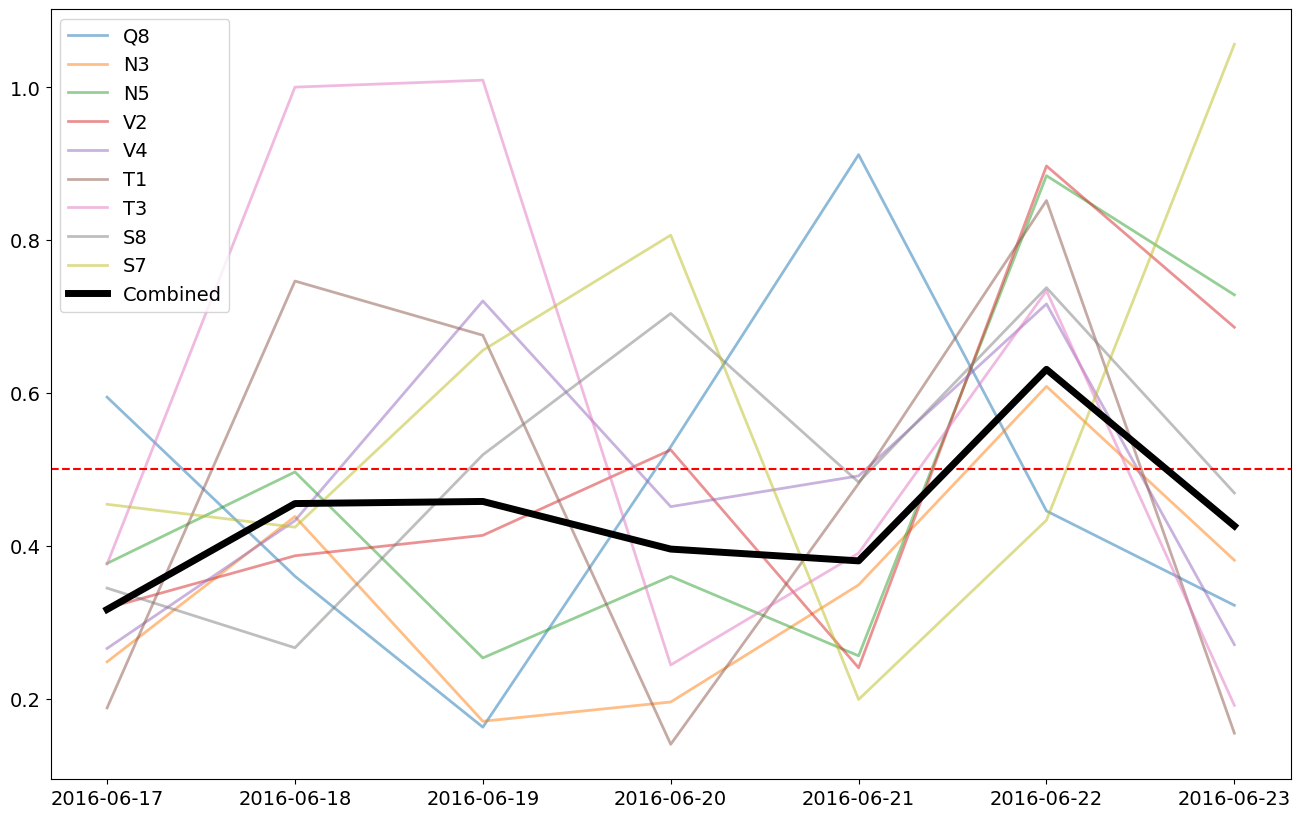

In [10]:
plt.figure(figsize=(16,10))
all_data = np.zeros(7)

for reg in daily_CSI.region:
    if reg == 'Q2':
        continue
    data = daily_CSI.sel(region=reg, time=slice('2016-06-17', '2016-06-23'))
    plt.plot(data.time, data, label=reg.data, lw=2, alpha=0.5, ls='-')

    # rolling_data = daily_CSI.rolling(time=7, center=False).mean().sel(region=reg, time=slice('2016-06-17', '2016-06-23'))
    all_data += data.data / 10

# plt.axvline(data.time.data[3], color='r', ls='--')
plt.axhline(0.5, color='r', ls='--')
plt.plot(data.time, all_data, lw=5, c='black', label='Combined')
plt.legend()
plt.show()

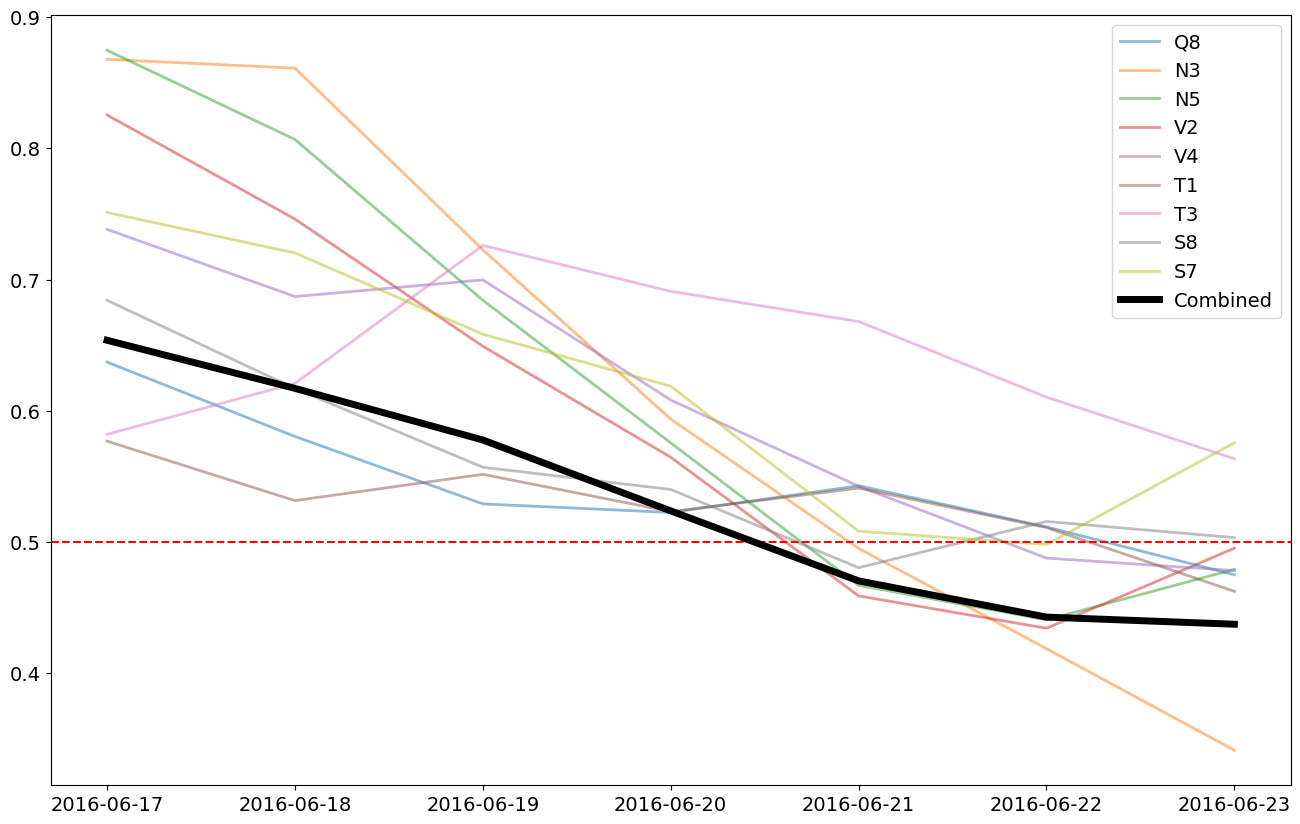

In [54]:
plt.figure(figsize=(16,10))
all_data = np.zeros(7)

for reg in daily_CSI.region:
    if reg == 'Q2':
        continue
    data = daily_CSI.rolling(time=7).mean().sel(region=reg, time=slice('2016-06-17', '2016-06-23'))
    plt.plot(data.time, data, label=reg.data, lw=2, alpha=0.5, ls='-')

    # rolling_data = daily_CSI.rolling(time=7, center=False).mean().sel(region=reg, time=slice('2016-06-17', '2016-06-23'))
    all_data += data.data / 10

# plt.axvline(data.time.data[3], color='r', ls='--')
plt.axhline(0.5, color='r', ls='--')
plt.plot(data.time, all_data, lw=5, c='black', label='Combined')
plt.legend()
plt.show()

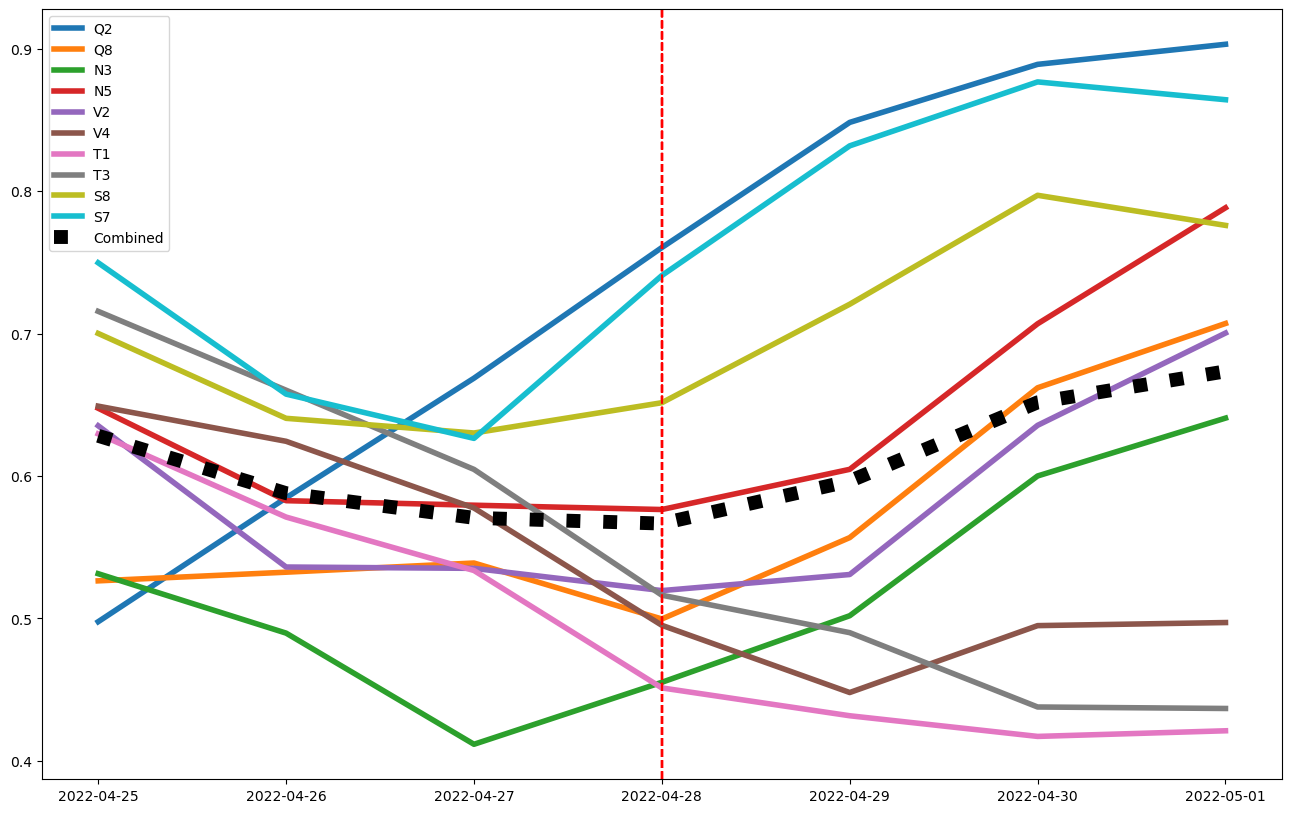

In [27]:
plt.figure(figsize=(16,10))
all_data = np.zeros(7)
for reg in daily_CSI.region:
    data = daily_CSI.rolling(time=7, center=True).mean().sel(region=reg, time=slice('2022-04-25', '2022-05-01'))
    plt.plot(data.time, data, label=reg.data, lw=4)
    plt.axvline(data.time.data[3], color='r', ls='--')

    all_data += data.data / 10

plt.plot(data.time, all_data, linestyle = ':', lw=10, c='black', label='Combined')
plt.legend()
plt.show()